In [1]:
import pandas as pd
import numpy as np

from shutil import copy
from copy import deepcopy
from sklearn.ensemble import RandomForestClassifier
from actsnclass.metrics import get_snpcc_metric
from actsnfink import *
import matplotlib.pylab as plt
import pickle
from actsnclass.metrics import get_snpcc_metric
from astropy.time import Time


import requests
import io
import os

In [2]:
train_first_model = False
strategy = 'UncSampling'            # query strategy

In [3]:
if train_first_model:
    #########     User choices: general    #########################
    
    create_matrix = False            # create raw data file by combining all TNS + a few simbad files
    n_files_simbad = 5              # number of simbad files randomly chosen to compose the raw data
    initial_state_from_file = False  # read initial state from a fixed file
    
    fname_features_matrix = '/media/emille/git/Fink/supernova_al/referee/data/features.csv'               # output features file
    fname_raw_output = '/media/emille/git/Fink/supernova_al/referee/data/raw.csv.gz'                      # output raw data file
    dirname_input = '../../../data/AL_data/'     # input directory with labelled alerts
    dirname_output = '../data/initial_state/'     # root products output directory
    append_name = ''                             # append to all metric, prob and queries names
    
    nloops = 30                          # number of learning loops
    initial_training = 10               # total number of objs in initial training
    frac_Ia_tot = 0.5                   # fraction of Ia in initial training 
    n_realizations = 1                  # total number of realizations
    n_realizations_ini = 0              # start from this realization number
    new_raw_file = False                 # save raw data in one file
    input_raw_file = fname_raw_output   # name of raw data file
    n = 15000                           # number of random simbad objects per file 
                                        # to be used as part of the raw data
    
    drop_zeros = True                   # ignore objects with observations in only 1 filter
    screen = True                       # print debug comments to screen
    
    ######################################
    # create directory structure

    features_names = ['a_g', 'b_g', 'c_g', 'snratio_g', 'mse_g', 'nrise_g', 
                      'a_r', 'b_r', 'c_r', 'snratio_r', 'mse_r', 'nrise_r']
    
    for name in [dirname_output + '/', 
                 dirname_output + '/' + strategy + '/', 
                 dirname_output + '/' + strategy + '/models/', 
                 dirname_output + '/' + strategy + '/class_prob/',
                 dirname_output + '/' + strategy + '/metrics/', 
                 dirname_output + '/' + strategy + '/queries/',
                 dirname_output + '/' + strategy + '/training_samples/', 
                 dirname_output + '/' + strategy + '/test_samples/']:
        if not os.path.isdir(name):
            os.makedirs(name) 
    
    ######################################
    # read initial data
    matrix_clean = pd.read_csv(fname_features_matrix, comment='#')  
    
    # define output files
    output_metrics_file = dirname_output + '/' + strategy + '/metrics/metrics_' + \
                          strategy + '.dat'
    output_queried_file = dirname_output + '/' + strategy + '/queries/queried_' + \
                          strategy + '.dat'
    output_prob_root = dirname_output + '/' + strategy + '/class_prob/class_prob_' + \
                           strategy
    
    #build samples        
    data = build_samples(matrix_clean, initial_training=initial_training, screen=True)
        
    # save initial data        
    train = pd.DataFrame(data.train_features, columns=features_names)
    train['objectId'] = data.train_metadata['id'].values
    train['type'] = data.train_metadata['type'].values
    train.to_csv(dirname_output + '/' + strategy + '/training_samples/train_before_loop.csv', index=False)
        
    test = pd.DataFrame(data.test_features, columns=features_names)
    test['objectId'] = data.test_metadata['id'].values
    test['type'] = data.test_metadata['type'].values
    test.to_csv(dirname_output + '/' + strategy + '/test_samples/test_before_loop.csv', index=False)        
    
    # perform learnin loop
    learn_loop(data, nloops=nloops, strategy=strategy, 
               output_metrics_file=output_metrics_file, 
               output_queried_file=output_queried_file,
               classifier='RandomForest', seed=None,
               batch=1, screen=True, output_prob_root=output_prob_root)    

In [4]:
if train_first_model:

    # read queried objects
    queried = pd.read_csv(dirname_output + '/' + strategy + '/queries/queried_UncSampling.dat', 
                          index_col=False, skiprows=1, names=['loop', 'objectId', 'type'] + \
                          list(train.keys())[:-3])
    
    # make sure queries are not already in training
    flag = np.array([item not in train['objectId'].values for item in queried['objectId'].values])
    
    # add loop column to original training
    train['loop'] = -1

    # add query to training
    train_after_loop = pd.concat([train, queried[flag]], ignore_index=True)
    
    # remove query from test
    flag_train = np.array([item in train_after_loop['objectId'].values 
                           for item in test['objectId'].values])
    test_after_loop = test[~flag_train]

    # save train and test to file
    train_after_loop.to_csv(dirname_output + '/' + strategy + \
                                           '/training_samples/train_after_loop.csv', 
                                           index=False)

    test_after_loop.to_csv(dirname_output + '/' + strategy + \
                                           '/test_samples/test_after_loop.csv', 
                                           index=False)

In [5]:
# read train and test data for loop
train_for_loop = pd.read_csv( '../data/initial_state/' + strategy + \
                                           '/training_samples/train_after_loop.csv', 
                                           index_col=False)

test_for_loop = pd.read_csv('../data/initial_state/' + strategy + \
                                           '/test_samples/test_after_loop.csv', 
                                           index_col=False)

In [6]:
# train model
clf = RandomForestClassifier(random_state=42, n_estimators=1000)
clf.fit(train_for_loop[list(train_for_loop.keys())[:-3]], train_for_loop['type'].values == 'Ia')

RandomForestClassifier(n_estimators=1000, random_state=42)

In [7]:
# make predictions
pred = clf.predict(test_for_loop[list(test_for_loop.keys())[:-2]])
pred_prob = clf.predict_proba(test_for_loop[list(test_for_loop.keys())[:-2]])

# calculate metrics
get_snpcc_metric(pred, test_for_loop['type'].values == 'Ia')

(['accuracy', 'efficiency', 'purity', 'fom'],
 [np.float64(0.9439646092268801),
  np.float64(0.26212980466288593),
  np.float64(0.7234782608695652),
  np.float64(0.12211198067162438)])

In [8]:
# save mode
pickle.dump(clf, open('../data/initial_state/' + strategy + '/models/model.pkl', 
                      'wb'))

In [9]:
# labels from 2.3m SSO, Australia
# here I used the date one day after it was sent to make sure to include all points regardless
# of when the night started

new_labels = {}
new_labels['20230921'] = np.array([['ZTF23abecphw', 'other', Time('2023-09-25', format='iso').jd]])
new_labels['20230925'] = np.array([['ZTF23abdhvou', 'Ia', Time('2023-09-26', format='iso').jd]])
new_labels['20230928'] = np.array([['ZTF23abceaws', 'other', Time('2023-10-01', format='iso').jd]])
new_labels['20231005'] = np.array([['ZTF23abhtkba', 'other', Time('2023-10-06', format='iso').jd],
                                   ['ZTF23abeudve', 'Ia', Time('2023-10-06', format='iso').jd],
                                   ['ZTF23abggbdy', 'Ia', Time('2023-10-06', format='iso').jd]])
new_labels['20231009'] = np.array([['ZTF23abhafym', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abgspys', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abglsmj', 'Ia', Time('2023-10-10', format='iso').jd]])
new_labels['20231012'] = np.array([['ZTF23abghfyg', 'Ia', Time('2023-10-13', format='iso').jd]])
new_labels['20231013'] = np.array([['ZTF23abgspvs', 'Ia', Time('2023-10-14', format='iso').jd],
                                   ['ZTF23abgnfdv', 'Ia', Time('2023-10-14', format='iso').jd],
                                  ['ZTF23abhzwll', 'Ia', Time('2023-10-14', format='iso').jd],
                                   ['ZTF23abhublj', 'Ia', Time('2023-10-14', format='iso').jd]])
new_labels['20231015'] = np.array([['ZTF23abhailb', 'other', Time('2023-10-16', format='iso').jd],
                                  ['ZTF23abgfwhj', 'Ia', Time('2023-10-16', format='iso').jd]])
new_labels['20231016'] = np.array([['ZTF23abihzbq', 'Ia', Time('2023-10-17', format='iso').jd]])
new_labels['20231018'] = np.array([['ZTF23abhvsbo', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abiljba', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abhzlbh', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abixwfv', 'other', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abidsaw', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abhzoyw', 'Ia', Time('2023-10-19', format='iso').jd]])
new_labels['20231019'] = np.array([['ZTF23abkavcl', 'Ia', Time('2023-10-20', format='iso').jd],
                                   ['ZTF23abjzkqu', 'Ia', Time('2023-10-20', format='iso').jd],
                                   ['ZTF23abkgdei', 'Ia', Time('2023-10-20', format='iso').jd],
                                   ['ZTF23abidmwl', 'other', Time('2023-10-20', format='iso').jd],
                                  ['ZTF23abjhbcr', 'other', Time('2023-10-20', format='iso').jd]])
new_labels['20231022'] = np.array([['ZTF23abjtozz', 'Ia', Time('2023-10-23', format='iso').jd]])
new_labels['20240224'] = np.array([['ZTF24aaejkyp', 'other', Time('2024-02-25', format='iso').jd]])
new_labels['20240229'] = np.array([['ZTF24aaegskb', 'Ia', Time('2024-03-01', format='iso').jd]])
new_labels['20240404'] = np.array([['ZTF24aahgtjt', 'Ia', Time('2024-04-05', format='iso').jd]])
new_labels['20240405'] = np.array([['ZTF24aahgqwk', 'other', Time('2024-04-06', format='iso').jd],
                                  ['ZTF24aahtdhb', 'other', Time('2024-04-06', format='iso').jd]])
new_labels['20240409'] = np.array([['ZTF24aahznij', 'Ia', Time('2024-04-10', format='iso').jd],
                                  ['ZTF24aahuulq', 'Ia', Time('2024-04-10', format='iso').jd],
                                  ['ZTF24aaibdjb', 'other', Time('2024-04-10', format='iso').jd]])
new_labels['20240410'] = np.array([['ZTF24aaiftcp', 'Ia', Time('2024-04-11', format='iso').jd],
                                  ['ZTF24aaiehwu', 'Ia', Time('2024-04-11', format='iso').jd]])
new_labels['20240412'] = np.array([['ZTF24aaindpx', 'Ia', Time('2024-04-13', format='iso').jd]])
new_labels['20240413'] = np.array([['ZTF24aaiypmp', 'Ia', Time('2024-04-14', format='iso').jd]])
new_labels['20240417'] = np.array([['ZTF24aaieino', 'Ia', Time('2024-04-18', format='iso').jd],
                                  ['ZTF24aahznij', 'Ia', Time('2024-04-18', format='iso').jd]])
new_labels['20240418'] = np.array([['ZTF24aaiigrt', 'Ia', Time('2024-04-21', format='iso').jd],
                                  ['ZTF24aaiafkl', 'other', Time('2024-04-19', format='iso').jd]])
new_labels['20240421'] = np.array([['ZTF24aaikjjk', 'other', Time('2024-04-22', format='iso').jd]])
new_labels['20240423'] = np.array([['ZTF24aajqamj', 'other', Time('2024-04-24', format='iso').jd]])
new_labels['20240503'] = np.array([['ZTF24aajwajo', 'other', Time('2024-05-04', format='iso').jd],
                                  ['ZTF24aajqwsm', 'Ia', Time('2024-05-04', format='iso').jd]])
new_labels['20240504'] = np.array([['ZTF24aakfchb', 'other', Time('2024-05-05', format='iso').jd]])
new_labels['20240505'] = np.array([['ZTF24aakymro', 'Ia', Time('2024-05-06', format='iso').jd],
                                  ['ZTF24aalpgky', 'other', Time('2024-05-06', format='iso').jd]])
new_labels['20240507'] = np.array([['ZTF24aalhjeu', 'other', Time('2024-05-08', format='iso').jd],
                                  ['ZTF24aalhjml', 'Ia', Time('2024-05-08', format='iso').jd],
                                   ['ZTF24aalsuwb', 'Ia', Time('2024-05-08', format='iso').jd],
                                  ['ZTF24aalcflg', 'Ia', Time('2024-05-08', format='iso').jd]])
new_labels['20240508'] = np.array([['ZTF24aakyqxt', 'Ia', Time('2024-05-09', format='iso').jd],
                                   ['ZTF24aalbzkr', 'Ia', Time('2024-05-09', format='iso').jd]])
new_labels['20240510'] = np.array([['ZTF24aalbkdo', 'Ia', Time('2024-05-11', format='iso').jd]])
new_labels['20240514'] = np.array([['ZTF24aamtsgz', 'Ia', Time('2024-05-15', format='iso').jd]])
new_labels['20240515'] = np.array([['ZTF24aamdfll', 'Ia', Time('2024-05-16', format='iso').jd]])


In [10]:
metrics_all_list = []
dir_output = '../data/'

for date in list(new_labels.keys()):

    print(date)
    
    # read previous training sample and trained model
    if date == list(new_labels.keys())[0]:
        train_for_loop = pd.read_csv(dir_output + 'initial_state/' + strategy + \
                                           '/training_samples/train_after_loop.csv', 
                                           index_col=False)
        
        clf_before = pickle.load(open(dir_output + 'initial_state/' + strategy + \
                                           '/models/model.pkl', 'rb'))
    else:
        is_file = False
        indx = list(new_labels.keys()).index(date) - 1
        
        while not is_file and indx >= 0:
            
            date_before = list(new_labels.keys())[indx]
            is_file = os.path.isfile(dir_output + date_before + \
                                          '/' + strategy  + \
                                          '/training_samples/train.csv')
            if is_file:
                train_for_loop = pd.read_csv(dir_output +  date_before + \
                                          '/' + strategy  + \
                                          '/training_samples/train.csv', 
                                          index_col=False)    
        
                clf_before = pickle.load(open(dir_output +  date_before + '/' + strategy + \
                                           '/models/model.pkl', 'rb'))
            else:
                indx = indx - 1

    ########################################################################
    ### create directory structure
    dirname_output = dir_output +  date + '/'
    
    for name in [dirname_output + '/', 
                 dirname_output + '/' + strategy + '/', 
                 dirname_output + '/' + strategy + '/models/', 
                 dirname_output + '/' + strategy + '/class_prob/',
                 dirname_output + '/' + strategy + '/metrics/', 
                 dirname_output + '/' + strategy + '/queries/',
                 dirname_output + '/' + strategy + '/training_samples/', 
                 dirname_output + '/' + strategy + '/test_samples/']:
        if not os.path.isdir(name):
            os.makedirs(name)

    #######################################################################
    ### Get alert data
    
    alerts_list = []

    for i in range(new_labels[date].shape[0]):
        
        name = new_labels[date][i][0]

        r = requests.post(
            'https://fink-portal.org/api/v1/objects',
            json={
                'objectId':name,
                'output-format': 'json'
            }
        )

        # Format output in a DataFrame
        pdf = pd.read_json(io.BytesIO(r.content))

        if pdf.shape[0] == 0:
            raise ValueError('No alerts found for object: ', name)
        
        # add label
        pdf['type'] = new_labels[date][i][1] 

        alerts_list.append(pdf)
    
    alerts_pd = pd.concat(alerts_list, ignore_index=True)

    #############################################################################
    #### feature extract
    
    alerts_format_list = []

    for indx_obj in range(new_labels[date].shape[0]):
        
        # isolate one object
        flag_obj = alerts_pd['i:objectId'].values == new_labels[date][indx_obj][0]

        # separate only dates until the alert was sent to follow-up
        cjd = alerts_pd[flag_obj]['i:jd'].values
        flag_jd = cjd < float(new_labels[date][indx_obj][2])
        
        #flag_jd = np.array([True for i in range(cjd.shape[0])])
        lc = pd.DataFrame([[new_labels[date][indx_obj][0], 
                        alerts_pd[flag_obj]['i:candid'].values[flag_jd][np.argsort(alerts_pd[flag_obj]['i:jd'].values[flag_jd])[-1]],
                        alerts_pd[flag_obj]['i:jd'].values[flag_jd],         
                        alerts_pd[flag_obj]['i:fid'].values[flag_jd], 
                        alerts_pd[flag_obj]['i:magpsf'].values[flag_jd],
                        alerts_pd[flag_obj]['i:sigmapsf'].values[flag_jd],
                        new_labels[date][indx_obj][1]]], 
                        columns=['objectId', 'candid', 'cjd', 'cfid', 'cmagpsf', 'csigmapsf', 'TNS'], index=[0], dtype=object)
    
        alerts_format_list.append(lc)

    alerts_format_pd = pd.concat(alerts_format_list, ignore_index=True)
    
    # convert from mag to FLUXCAL
    alerts_flux = convert_full_dataset(alerts_format_pd, obj_id_header='objectId')

    # extract features
    alerts_features = featurize_full_dataset(alerts_flux, screen=False,
                                             ewma_window=3, 
                                              min_rising_points=1, 
                                              min_data_points=3, rising_criteria='ewma')


    # filter alerts with zero in all filters
    flag_zero = np.logical_and(alerts_features['a_g'].values == 0.0,
                               alerts_features['a_r'].values == 0.0)

    alerts_use = deepcopy(alerts_features[~flag_zero])
    print('    alerts_use.shape = ', alerts_use.shape)
    
    if alerts_use.shape[0] > 0:
        alerts_use.rename(columns={'id':'objectId'}, inplace=True)
        alerts_use['loop'] = list(new_labels.keys()).index(date) + 30
    
        # see what current model says about queried alerts
        pred_prob_query = clf_before.predict_proba(alerts_use[list(alerts_use.keys())[2:-1]])
        
        # save to file
        prob_queries_before = pd.DataFrame(np.hstack([alerts_use['objectId'].values.reshape(-1,1), 
                           np.array(pred_prob_query[:,1]).reshape(-1,1)]), 
                              columns=['objectId','probIa_before'])
        prob_queries_before.to_csv(dir_output +  date + '/' + strategy + \
                                   '/queries/class_prob_before.csv', index=False)
    
        # update training
        train_updated = pd.concat([train_for_loop, alerts_use], ignore_index=True)
        print('    train_updated.shape = ', train_updated.shape)
    
        # save to file
        train_updated.to_csv(dir_output + date +'/' + strategy  + \
                                          '/training_samples/train.csv', 
                                           index=False)
    
        # train model
        clf = RandomForestClassifier(random_state=42, n_estimators=1000)
        clf.fit(train_updated[list(train_updated.keys())[:-3]], 
                    train_updated['type'].values == 'Ia')
    
        # make predictions
        pred = clf.predict(test_for_loop[list(test_for_loop.keys())[:-2]])
        pred_prob = clf.predict_proba(test_for_loop[list(test_for_loop.keys())[:-2]])
        
        # save mode
        pickle.dump(clf, open(dir_output + date + '/' + strategy + '/models/model.pkl', 
                                  'wb'))
    
        # save predictions
        pred_prob_pd = pd.DataFrame(np.hstack([test_for_loop['objectId'].values.reshape(-1,1), 
                                        np.array(pred_prob[:,1]).reshape(-1,1)]), 
                                        columns=['objectId','probIa'])
        pred_prob_pd.to_csv(dir_output +  date + '/' + strategy + \
                            '/class_prob/test_class_prob.csv', index=False)

        # calculate metrics
        names, res = get_snpcc_metric(pred, test_for_loop['type'].values == 'Ia')
        print('   res = ', res)
        
        metric_pd = pd.DataFrame([[date] + [list(new_labels.keys()).index(date) + 30] + res + \
                                     [list(alerts_use['objectId'].values)]],
                                    columns=['date','loop'] + names + ['query_objectIds'])
        metric_pd.to_csv(dir_output +  date +'/' + strategy  + \
                                          '/metrics/metric.csv', 
                                           index=False)
    
        metrics_all_list.append(metric_pd)
    
metrics_all_pd = pd.concat(metrics_all_list, ignore_index=True)

20230921
    alerts_use.shape =  (1, 14)
    train_updated.shape =  (41, 15)
   res =  [np.float64(0.942827048662313), np.float64(0.23944549464398235), np.float64(0.7169811320754716), np.float64(0.10962564815025698)]
20230925
    alerts_use.shape =  (1, 14)
    train_updated.shape =  (42, 15)
   res =  [np.float64(0.9424899936802191), np.float64(0.2432262129804663), np.float64(0.7018181818181818), np.float64(0.10693088634448747)]
20230928
    alerts_use.shape =  (0, 14)
20231005
    alerts_use.shape =  (3, 14)
    train_updated.shape =  (45, 15)
   res =  [np.float64(0.9394143669686118), np.float64(0.29930686830497794), np.float64(0.5930087390761548), np.float64(0.0978463609393424)]
20231009
    alerts_use.shape =  (2, 14)
    train_updated.shape =  (47, 15)
   res =  [np.float64(0.9370128502211923), np.float64(0.32136105860113423), np.float64(0.5495689655172413), np.float64(0.09291051013978369)]
20231012
    alerts_use.shape =  (0, 14)
20231013
    alerts_use.shape =  (4, 14)
    trai

In [11]:
metrics_all_pd.to_csv(dir_output + 'metrics.csv', index=False)

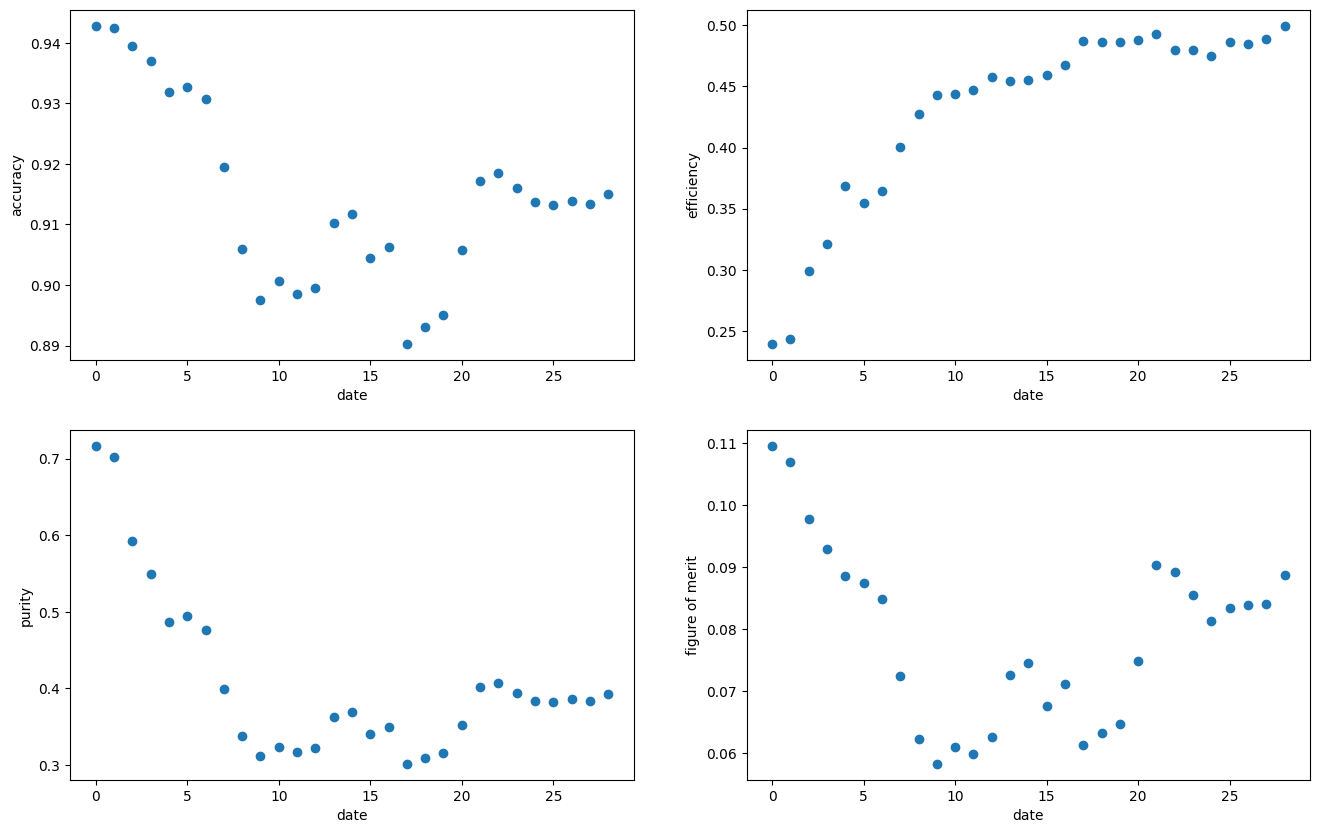

In [12]:
plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
plt.scatter(np.arange(metrics_all_pd.shape[0]), metrics_all_pd['accuracy'])
plt.xlabel('date')
plt.ylabel('accuracy')

plt.subplot(2,2,2)
plt.scatter(np.arange(metrics_all_pd.shape[0]), metrics_all_pd['efficiency'])
plt.xlabel('date')
plt.ylabel('efficiency')

plt.subplot(2,2,3)
plt.scatter(np.arange(metrics_all_pd.shape[0]), metrics_all_pd['purity'])
plt.xlabel('date')
plt.ylabel('purity')

plt.subplot(2,2,4)
plt.scatter(np.arange(metrics_all_pd.shape[0]), metrics_all_pd['fom'])
plt.xlabel('date')
plt.ylabel('figure of merit')

plt.show()

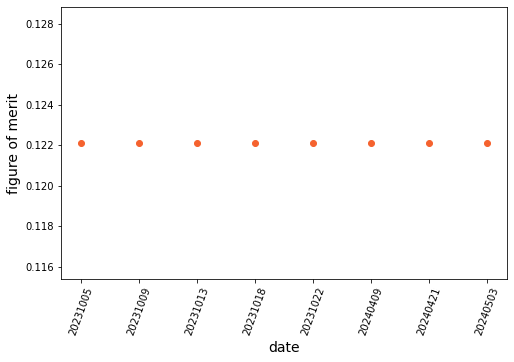

In [22]:
plt.figure(figsize=(8,5))

plt.scatter(np.arange(metrics_all_pd.shape[0]), metrics_all_pd['fom'], color='#F5622E')
plt.xlabel('date', fontsize=14)
plt.ylabel('figure of merit', fontsize=14)
plt.xticks(np.arange(metrics_all_pd.shape[0]), metrics_all_pd['date'], rotation=70)

plt.show()
#plt.savefig('../plots/fom.png')

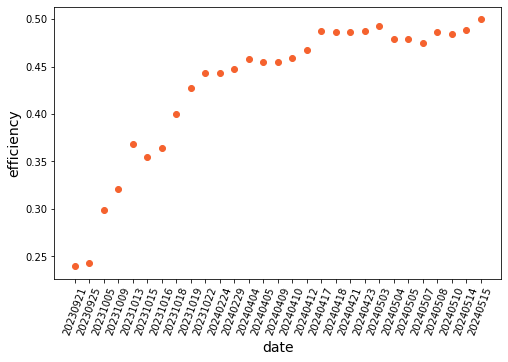

In [53]:
plt.figure(figsize=(8,5))

plt.scatter(np.arange(metrics_all_pd.shape[0]), metrics_all_pd['efficiency'], color='#F5622E')
plt.xlabel('date', fontsize=14)
plt.ylabel('efficiency', fontsize=14)
plt.xticks(np.arange(metrics_all_pd.shape[0]), metrics_all_pd['date'], rotation=70)

plt.savefig('../plots/efficiency.png')

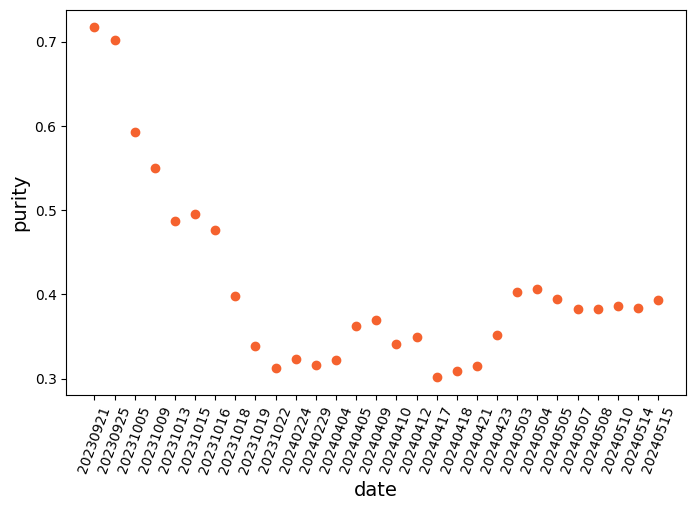

In [13]:
plt.figure(figsize=(8,5))

plt.scatter(np.arange(metrics_all_pd.shape[0]), metrics_all_pd['purity'], color='#F5622E')
plt.xlabel('date', fontsize=14)
plt.ylabel('purity', fontsize=14)
plt.xticks(np.arange(metrics_all_pd.shape[0]), metrics_all_pd['date'], rotation=70)

plt.show()
#plt.savefig('../plots/purity.png')

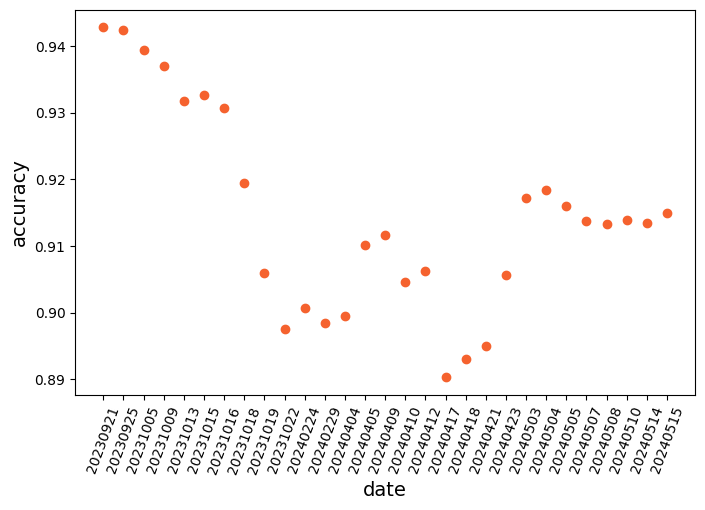

In [14]:
plt.figure(figsize=(8,5))

plt.scatter(np.arange(metrics_all_pd.shape[0]), metrics_all_pd['accuracy'], color='#F5622E')
plt.xlabel('date', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.xticks(np.arange(metrics_all_pd.shape[0]), metrics_all_pd['date'], rotation=70)

plt.show()
#plt.savefig('../plots/accuracy.png')

In [15]:
all_probs_list = []

for date in list(new_labels.keys()):
    fname = '../data/' + date + '/' + strategy + '/queries/class_prob_before.csv'
    
    if os.path.isfile(fname):
        data = pd.read_csv(fname)
        all_probs_list.append(data)
    
all_probs = pd.concat(all_probs_list, ignore_index=True)

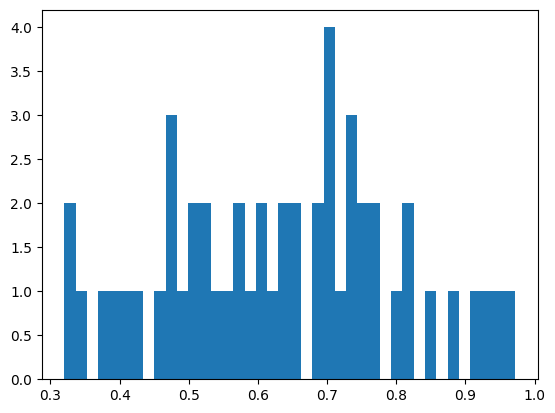

In [16]:
plt.figure()
plt.hist(all_probs['probIa_before'], bins=40)
plt.show()

In [17]:
all_probs

,objectId,probIa_before
0,ZTF23abecphw,0.626
1,ZTF23abdhvou,0.521
2,ZTF23abeudve,0.744
3,ZTF23abggbdy,0.391
4,ZTF23abhtkba,0.690
5,ZTF23abgspys,0.821
6,ZTF23abhafym,0.545
7,ZTF23abgnfdv,0.588
8,ZTF23abgspvs,0.407
9,ZTF23abhublj,0.329
